In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from typing import Tuple, Optional

In [5]:
class ddpm:
    def __init__(self, eps_model:nn.Module, n_steps:int, device: torch.device, beta_start:float=1e-4, beta_end:float=0.02):
        self.eps_model = eps_model # model
        self.beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
    
    @staticmethod
    def gather(const: torch.Tensor, t: torch.Tensor):
        c = const.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps
    
    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** 0.5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = self.gather(self.sigma2, t)
        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** 0.5) * eps
    
    def loss(self, x0: torch.Tensor, eps: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if eps is None:
            eps = torch.randn_like(x0)
        xt = self.q_sample(x0, t, eps)
        eps_theta = self.eps_model(xt, t)
        return F.mse_loss(eps, eps_theta)

    

In [14]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset setup helper
def get_mnist_dataloaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

# Training loop
def train_diffusion(
    ddpm_model,
    eps_model,
    dataloader,
    n_epochs=100,
    device="cuda",
    optimizer=None
):
    if optimizer is None:
        optimizer = torch.optim.Adam(eps_model.parameters(), lr=2e-4)
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader):
            x0, _ = batch
            x0 = x0.to(device)
            
            optimizer.zero_grad()
            loss = ddpm_model.loss(x0)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        print(f"Epoch {epoch}: Average Loss = {epoch_loss/len(dataloader):.4f}")

        # Generate and display samples every 10 epochs
        if epoch % 2 == 0:
            samples = sample_images(ddpm_model, n_samples=16)
            
            # Convert samples to display format
            samples = samples.cpu().numpy()
            samples = (samples + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
            samples = samples.clip(0, 1)
            
            # Create a grid of images
            fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            for i, ax in enumerate(axes.flat):
                ax.imshow(samples[i][0], cmap='gray')
                ax.axis('off')
            
            plt.suptitle(f'Samples at Epoch {epoch}')
            plt.tight_layout()
            plt.show()

# Sampling helper
def sample_images(ddpm_model, n_samples=16, size=(1, 28, 28), device="cuda"):
    with torch.no_grad():
        x = torch.randn((n_samples, *size)).to(device)
        
        for t in tqdm(range(ddpm_model.n_steps - 1, -1, -1)):
            t_batch = torch.tensor([t] * n_samples, device=device)
            x = ddpm_model.p_sample(x, t_batch)
            
    return x




In [15]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, time_dim=256):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
        
        # Decoder
        self.dec3 = nn.ConvTranspose2d(256 + time_dim, 128, 3, padding=1, stride=2, output_padding=1)
        self.dec2 = nn.ConvTranspose2d(128 + 128, 64, 3, padding=1, stride=2, output_padding=1)
        self.dec1 = nn.Conv2d(64 + 64, in_channels, 3, padding=1)
        
    def forward(self, x, t):
        # Time embedding
        t = t.unsqueeze(-1).float()
        t = self.time_mlp(t)
        
        # Encoder
        e1 = F.gelu(self.enc1(x))
        e2 = F.gelu(self.enc2(e1))
        e3 = F.gelu(self.enc3(e2))
        
        # Add time embedding
        t = t.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, e3.shape[2], e3.shape[3])
        e3 = torch.cat([e3, t], dim=1)
        
        # Decoder with skip connections
        d3 = F.gelu(self.dec3(e3))
        d2 = F.gelu(self.dec2(torch.cat([d3, e2], dim=1)))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))
        
        return d1


100%|██████████| 47/47 [00:21<00:00,  2.22it/s]


Epoch 0: Average Loss = 1.3695


100%|██████████| 1000/1000 [00:01<00:00, 503.44it/s]


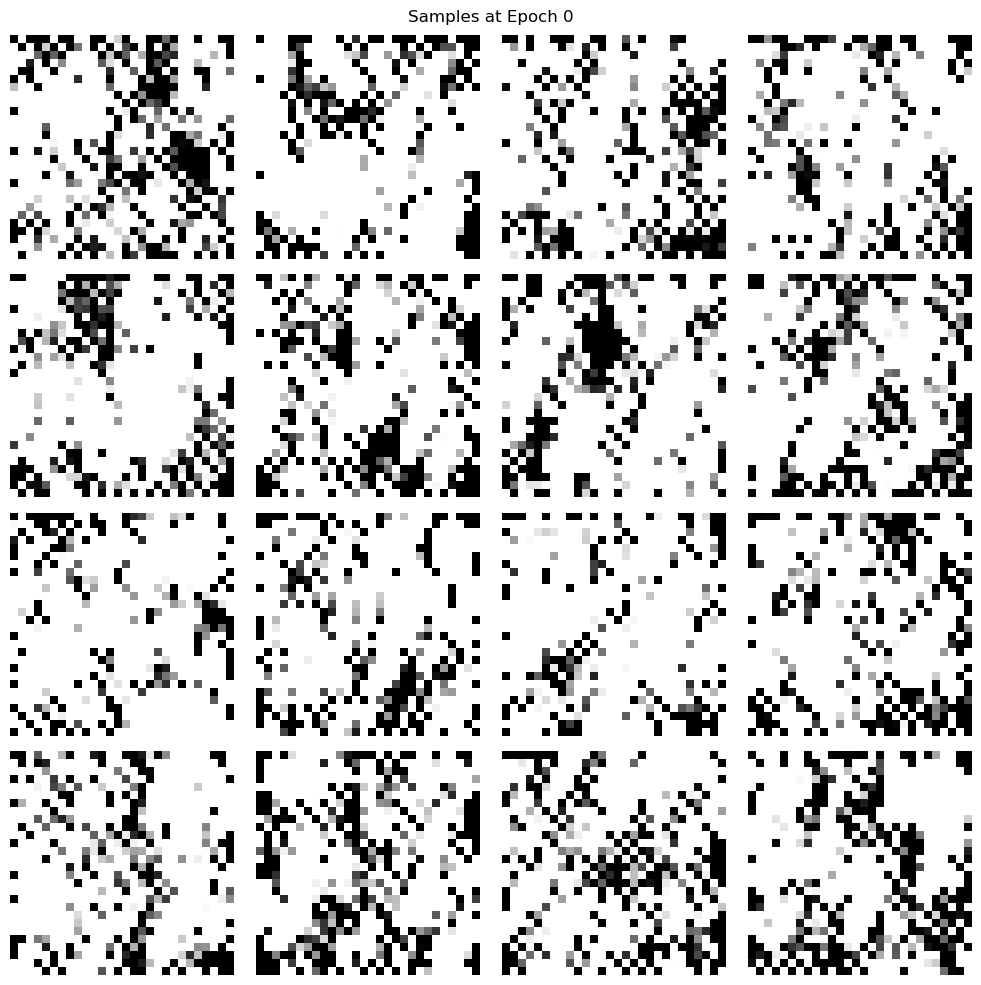

100%|██████████| 47/47 [00:21<00:00,  2.22it/s]


Epoch 1: Average Loss = 0.2725


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 2: Average Loss = 0.1865


100%|██████████| 1000/1000 [00:01<00:00, 508.21it/s]


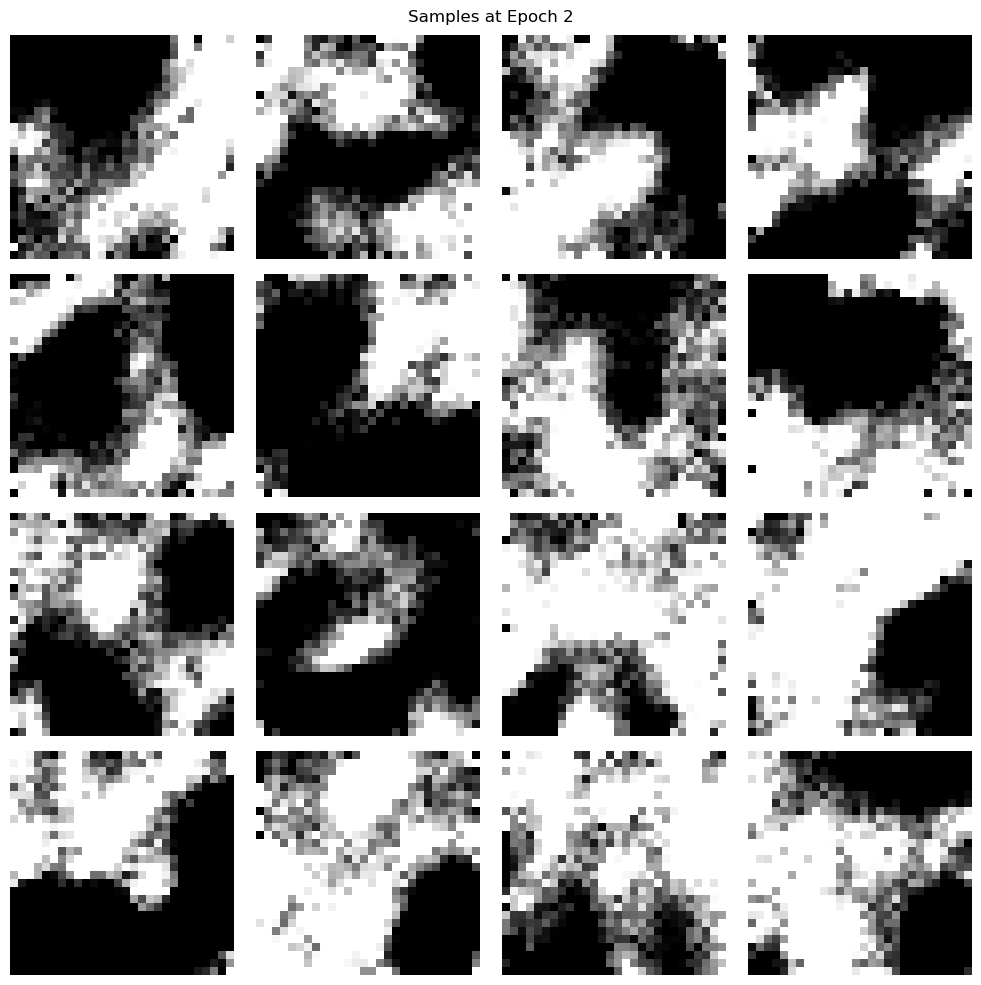

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 3: Average Loss = 0.1700


100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 4: Average Loss = 0.1603


100%|██████████| 1000/1000 [00:01<00:00, 529.05it/s]


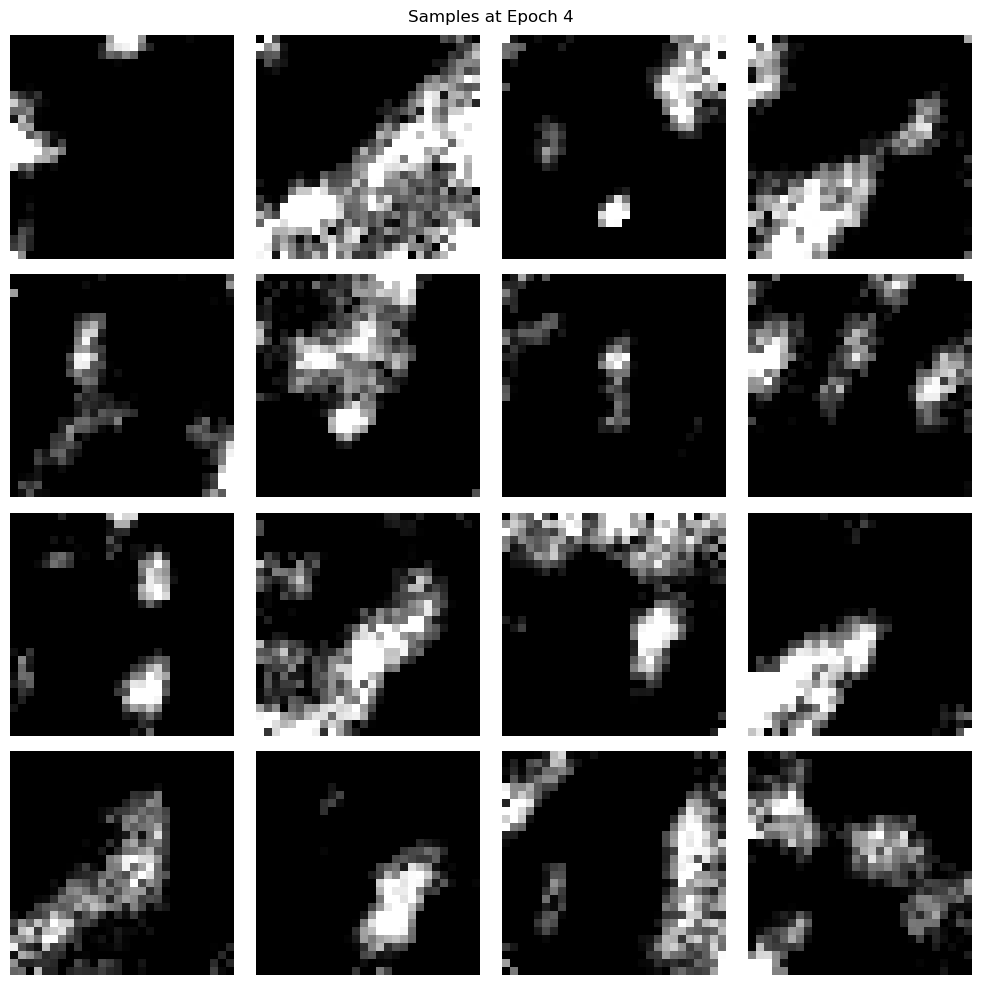

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 5: Average Loss = 0.1400


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 6: Average Loss = 0.1246


100%|██████████| 1000/1000 [00:01<00:00, 512.83it/s]


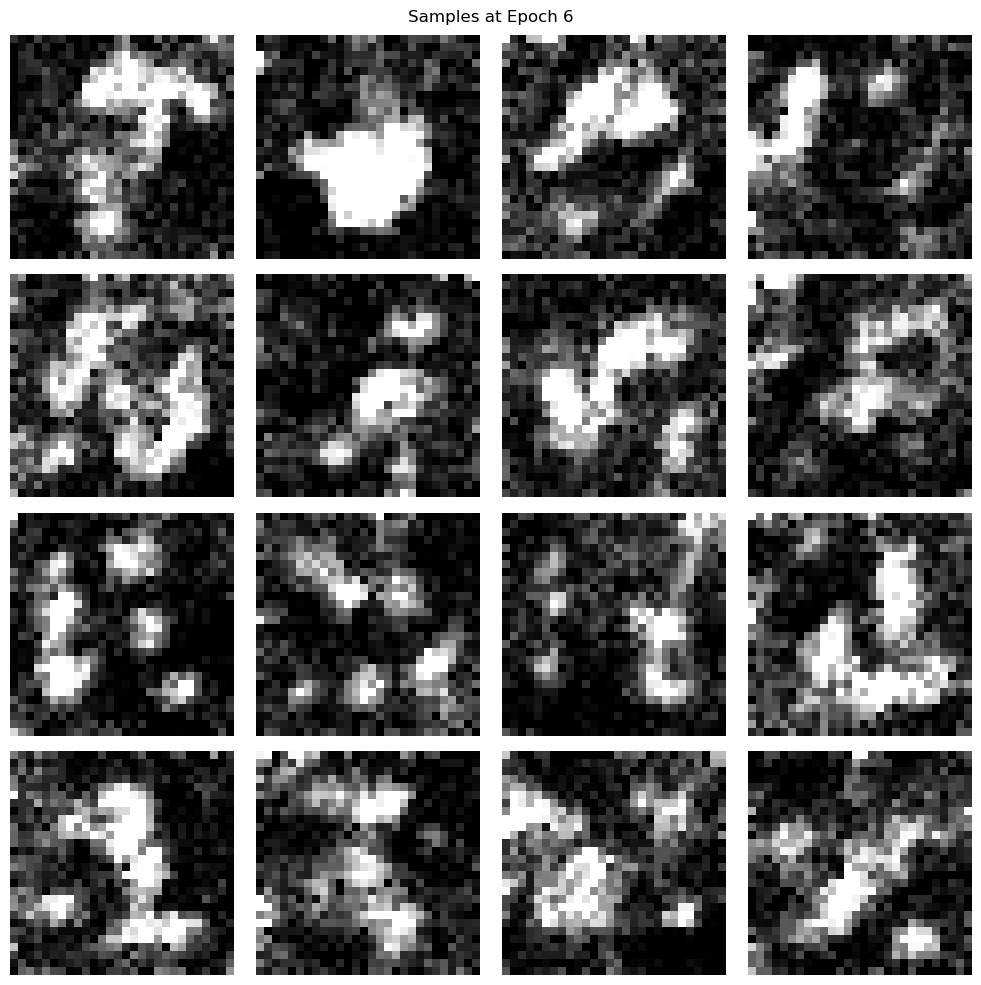

100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 7: Average Loss = 0.1108


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 8: Average Loss = 0.1073


100%|██████████| 1000/1000 [00:01<00:00, 510.85it/s]


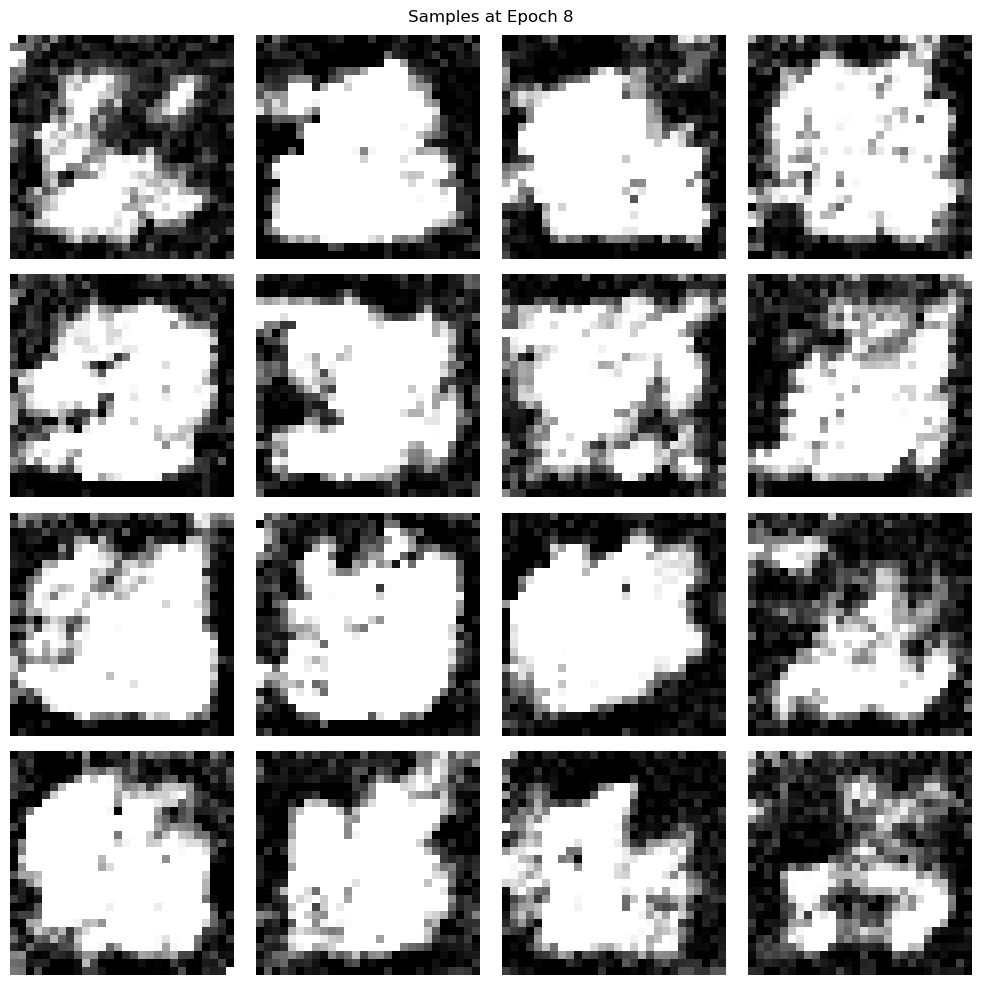

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 9: Average Loss = 0.1030


100%|██████████| 47/47 [00:21<00:00,  2.16it/s]


Epoch 10: Average Loss = 0.0918


100%|██████████| 1000/1000 [00:01<00:00, 516.87it/s]


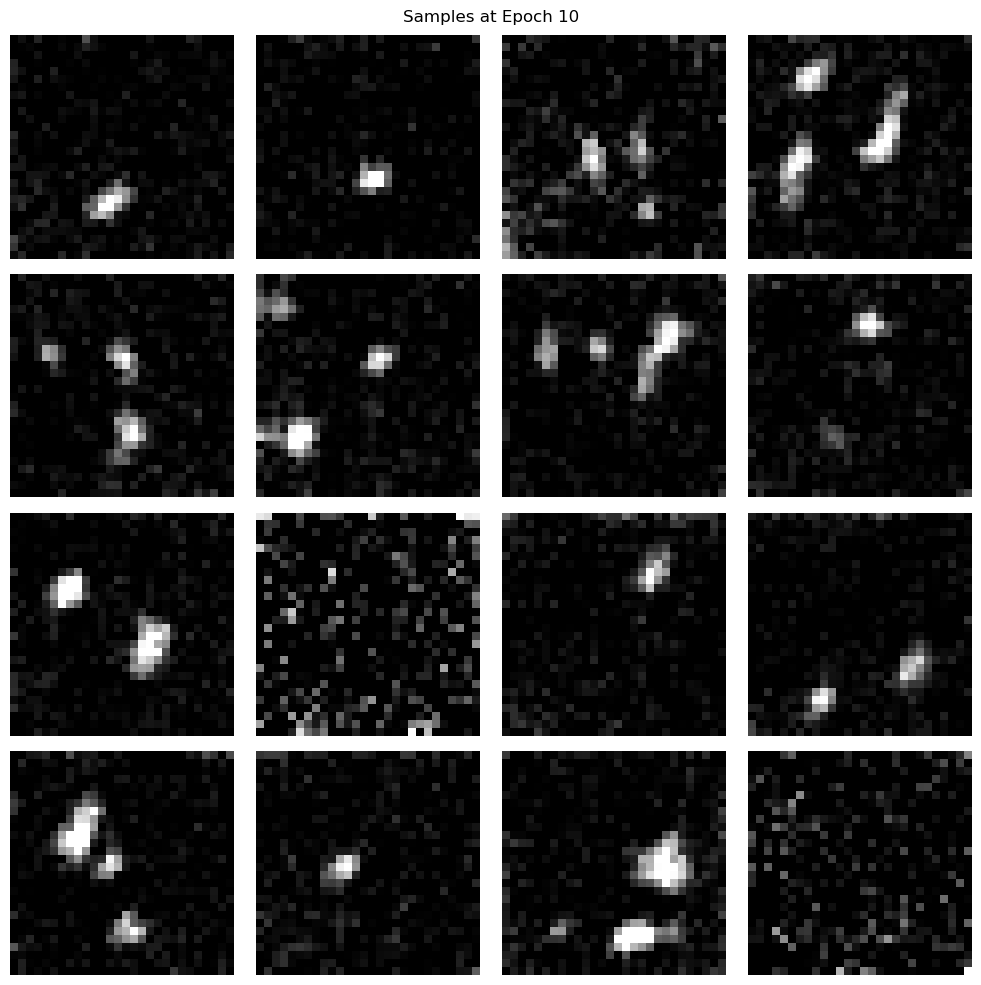

100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 11: Average Loss = 0.0924


100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 12: Average Loss = 0.0829


100%|██████████| 1000/1000 [00:01<00:00, 505.85it/s]


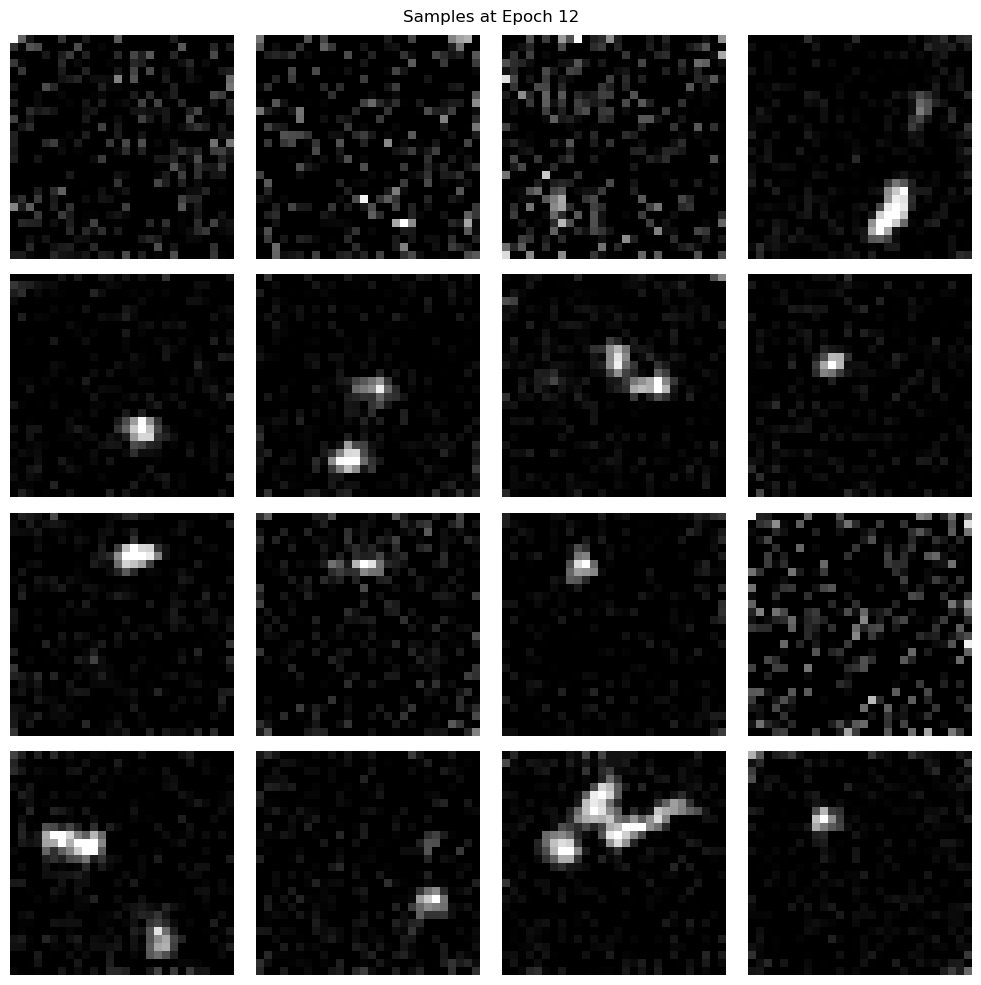

100%|██████████| 47/47 [00:21<00:00,  2.18it/s]


Epoch 13: Average Loss = 0.0804


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 14: Average Loss = 0.0788


100%|██████████| 1000/1000 [00:01<00:00, 508.71it/s]


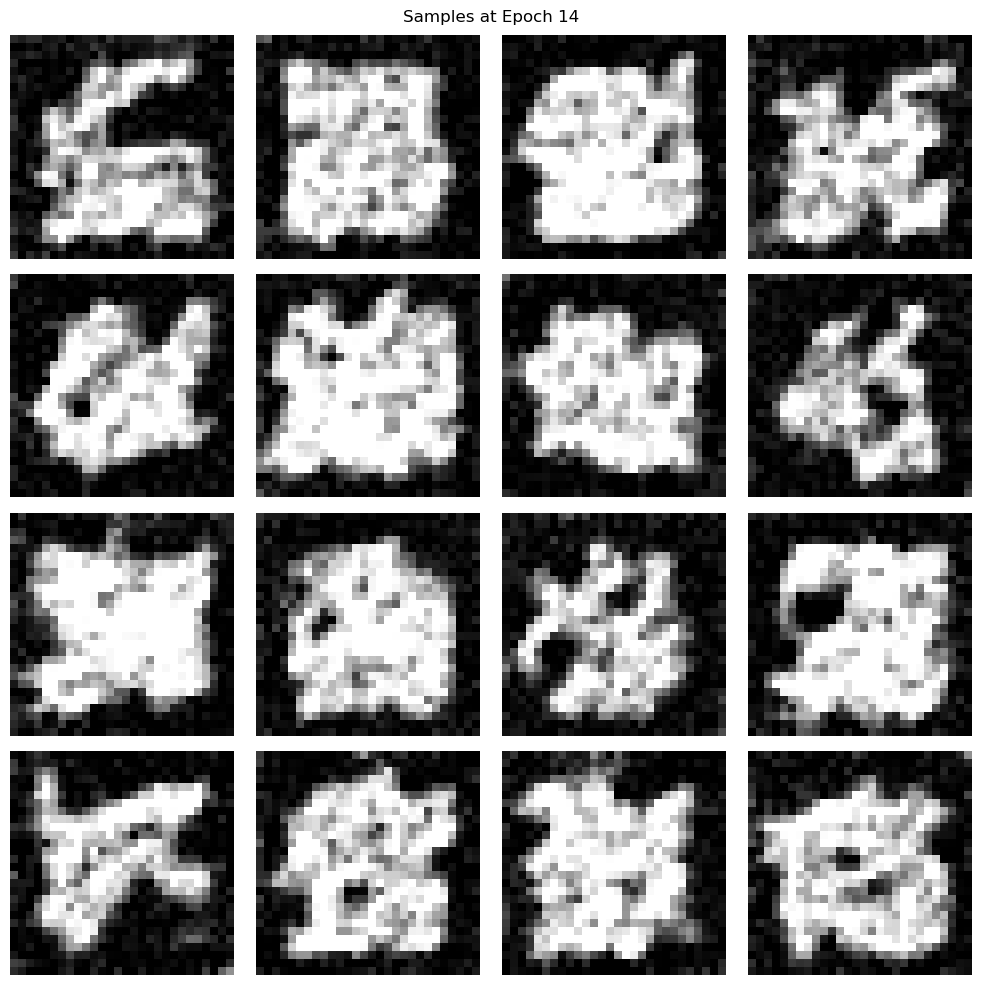

100%|██████████| 47/47 [00:21<00:00,  2.18it/s]


Epoch 15: Average Loss = 0.0837


100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 16: Average Loss = 0.0727


100%|██████████| 1000/1000 [00:01<00:00, 515.77it/s]


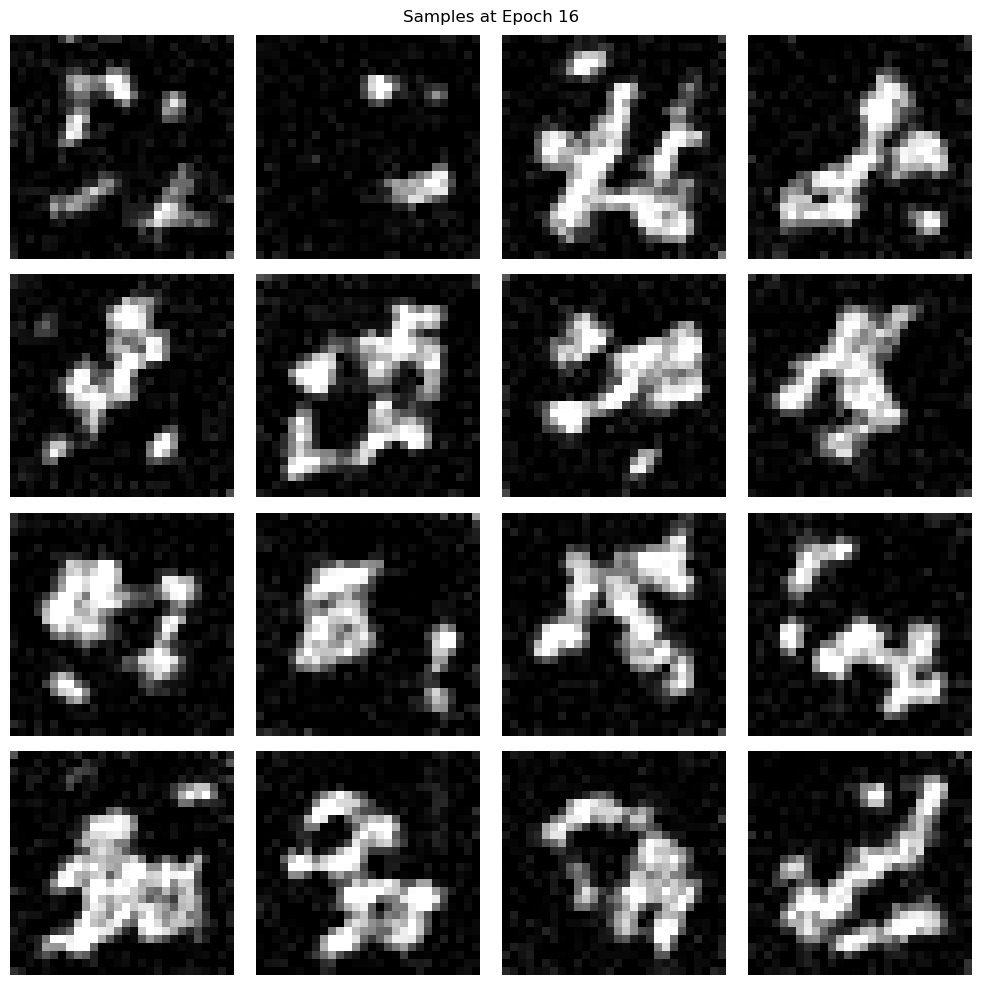

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 17: Average Loss = 0.0715


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 18: Average Loss = 0.0772


100%|██████████| 1000/1000 [00:01<00:00, 519.80it/s]


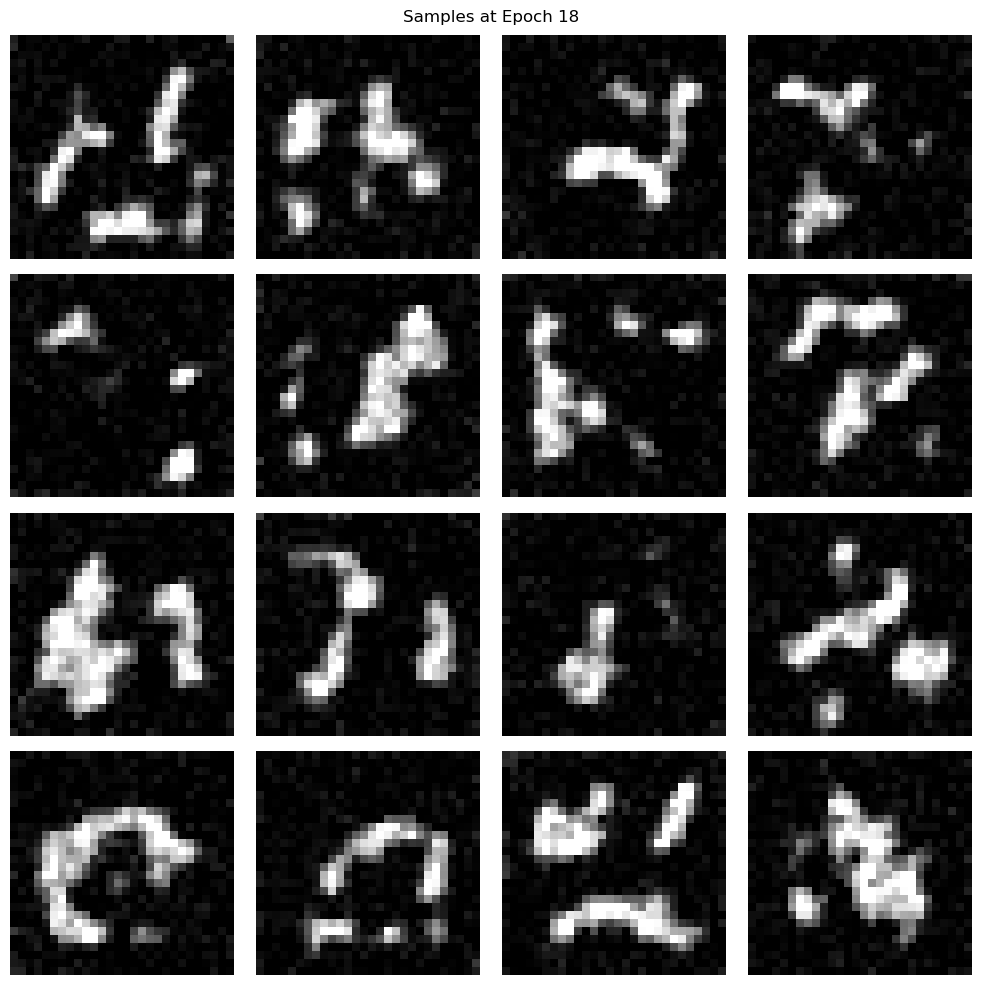

100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 19: Average Loss = 0.0686


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 20: Average Loss = 0.0695


100%|██████████| 1000/1000 [00:01<00:00, 512.17it/s]


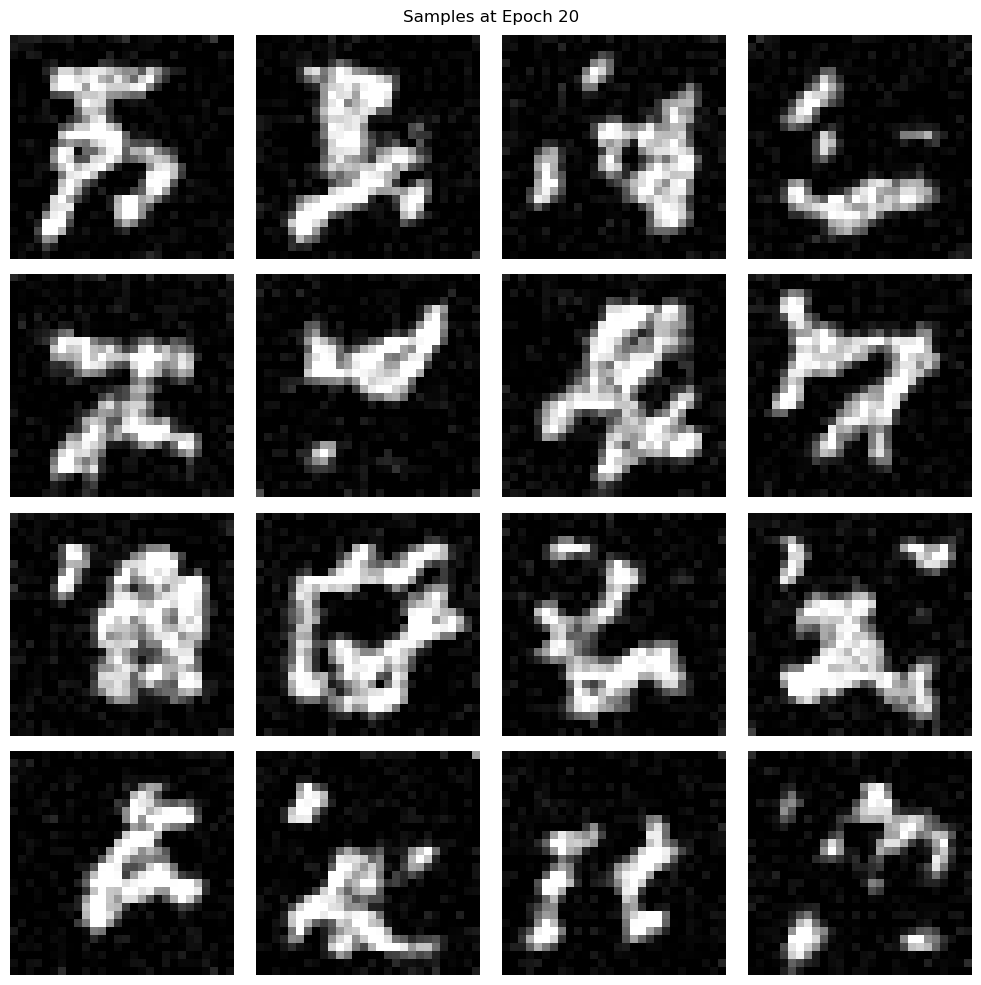

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 21: Average Loss = 0.0736


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 22: Average Loss = 0.0682


100%|██████████| 1000/1000 [00:01<00:00, 515.53it/s]


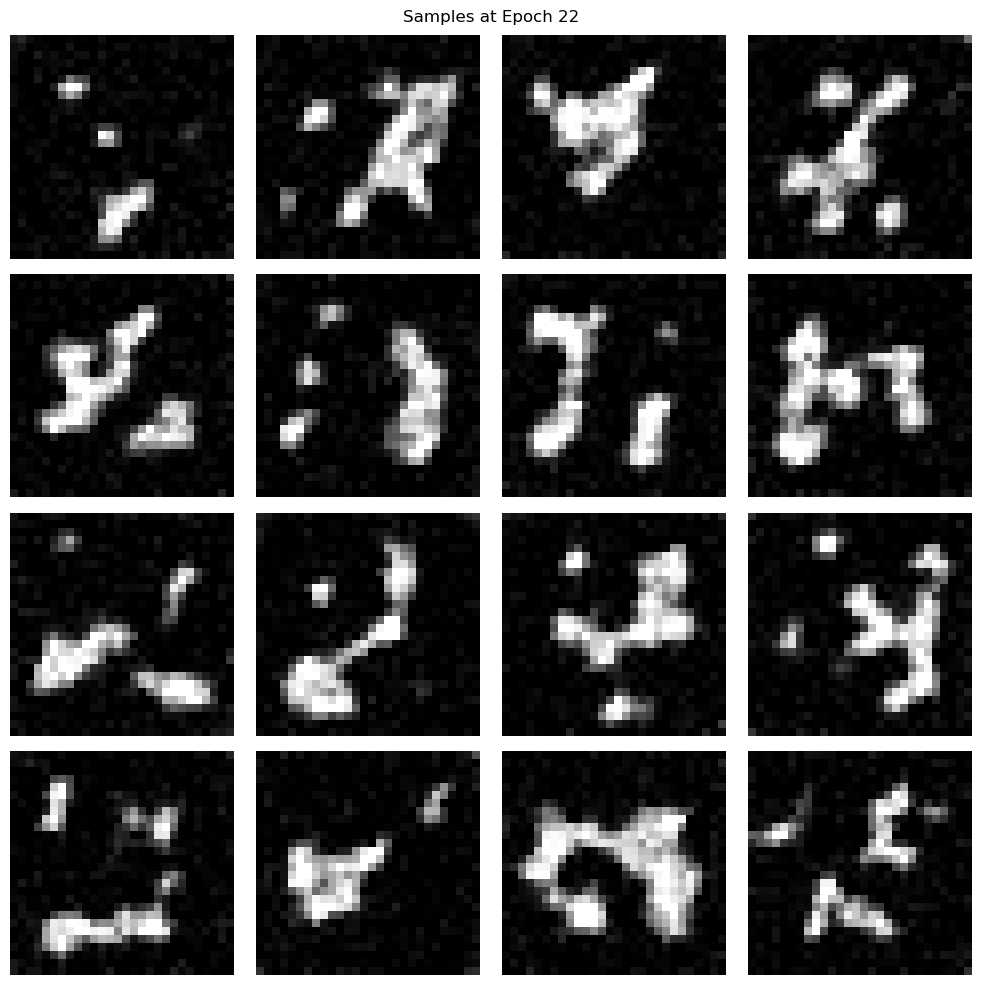

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 23: Average Loss = 0.0636


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 24: Average Loss = 0.0636


100%|██████████| 1000/1000 [00:01<00:00, 510.55it/s]


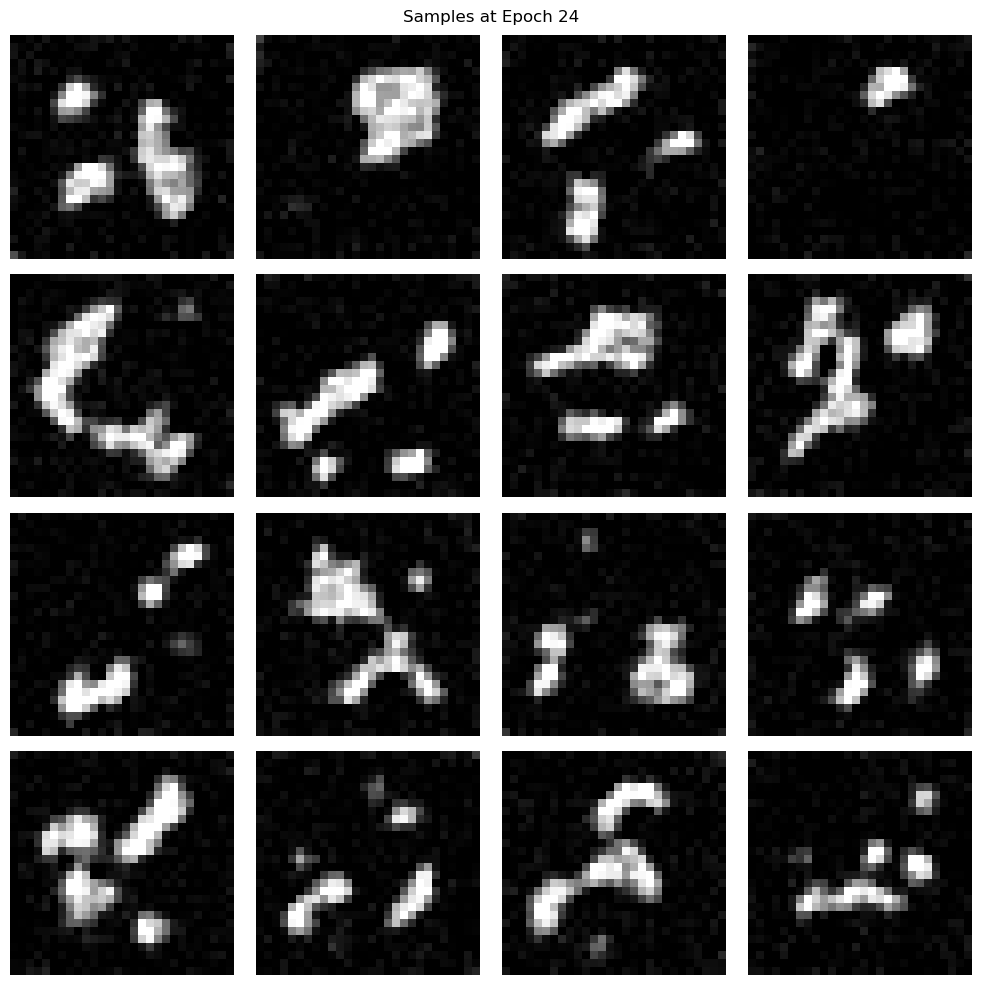

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 25: Average Loss = 0.0630


100%|██████████| 47/47 [00:21<00:00,  2.18it/s]


Epoch 26: Average Loss = 0.0621


100%|██████████| 1000/1000 [00:01<00:00, 520.65it/s]


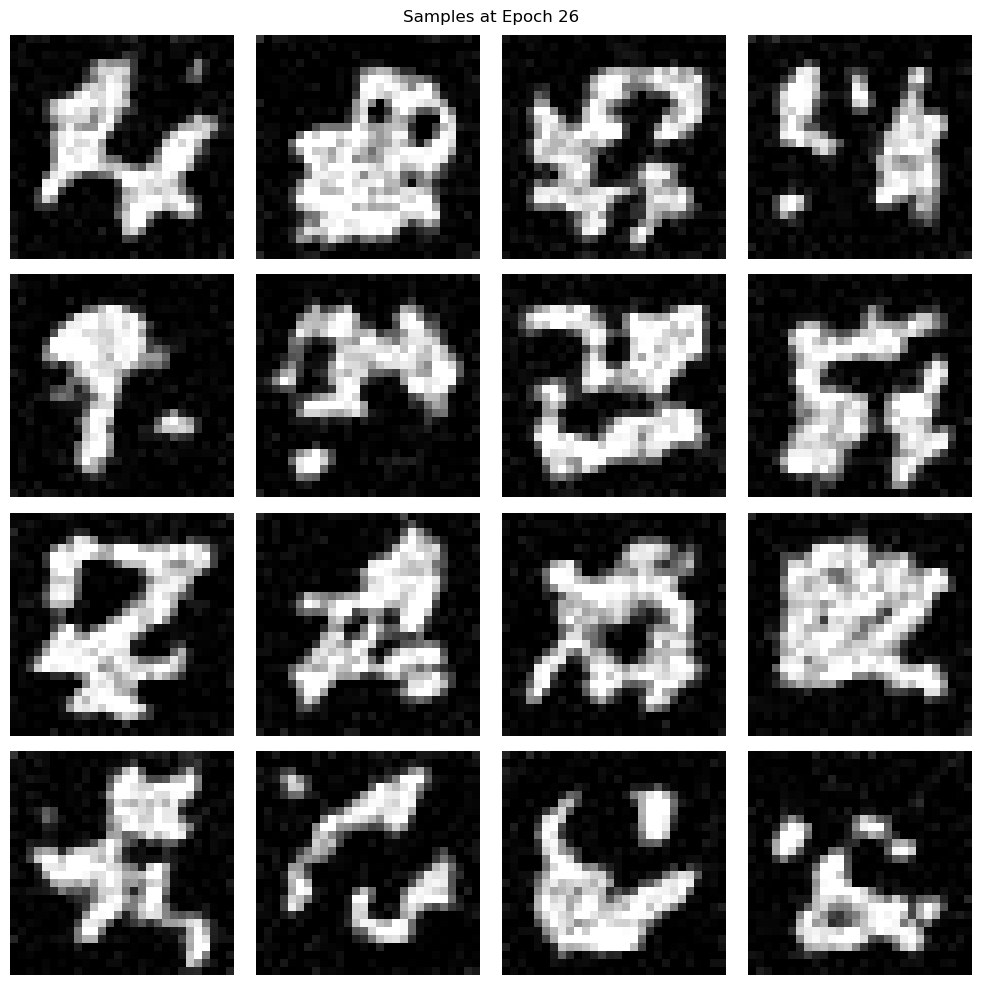

100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 27: Average Loss = 0.0617


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 28: Average Loss = 0.0606


100%|██████████| 1000/1000 [00:01<00:00, 519.95it/s]


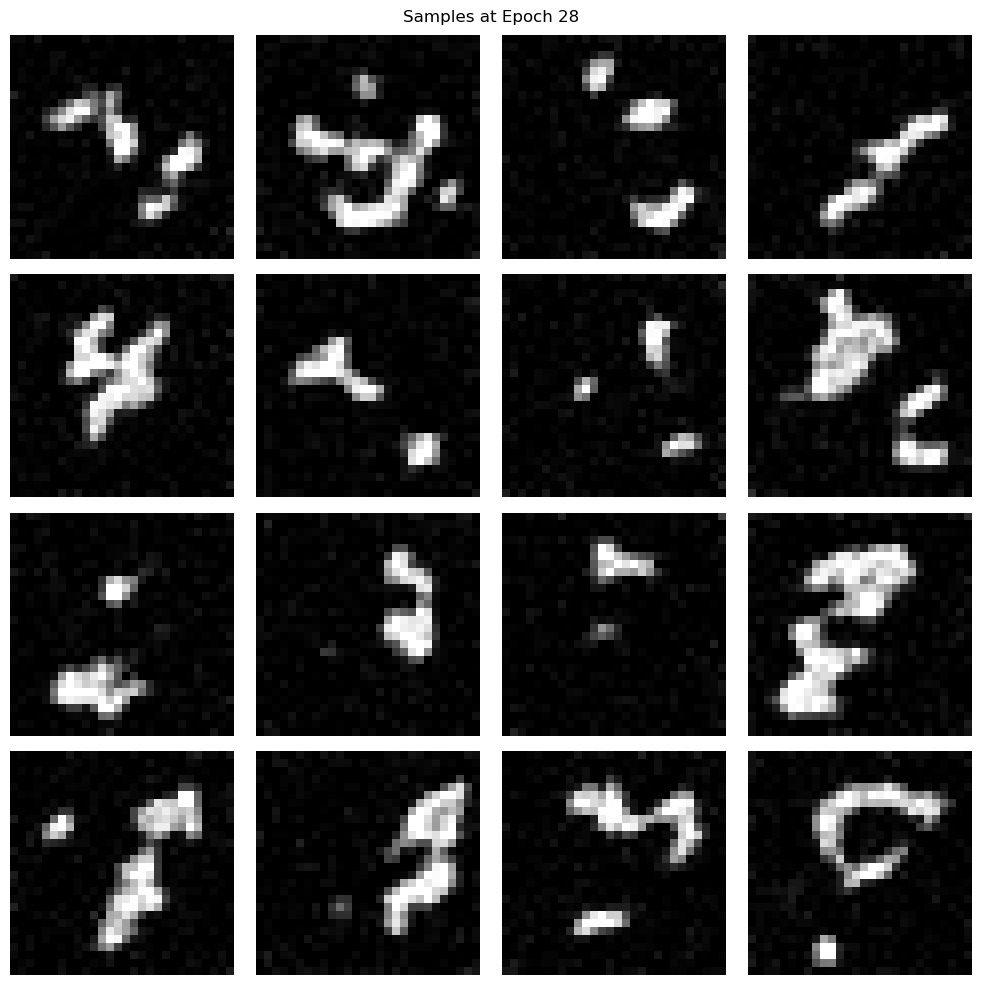

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 29: Average Loss = 0.0599


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 30: Average Loss = 0.0581


100%|██████████| 1000/1000 [00:01<00:00, 504.35it/s]


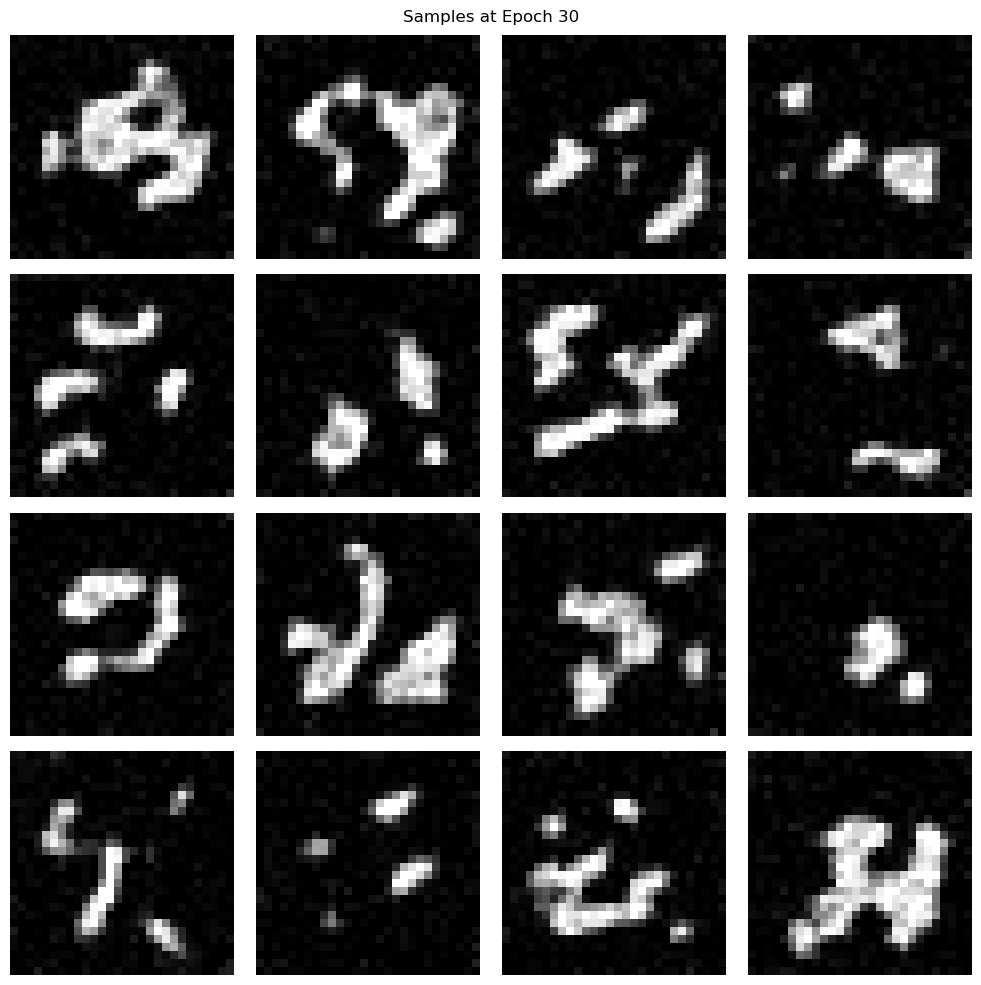

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 31: Average Loss = 0.0610


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 32: Average Loss = 0.1287


100%|██████████| 1000/1000 [00:02<00:00, 489.83it/s]


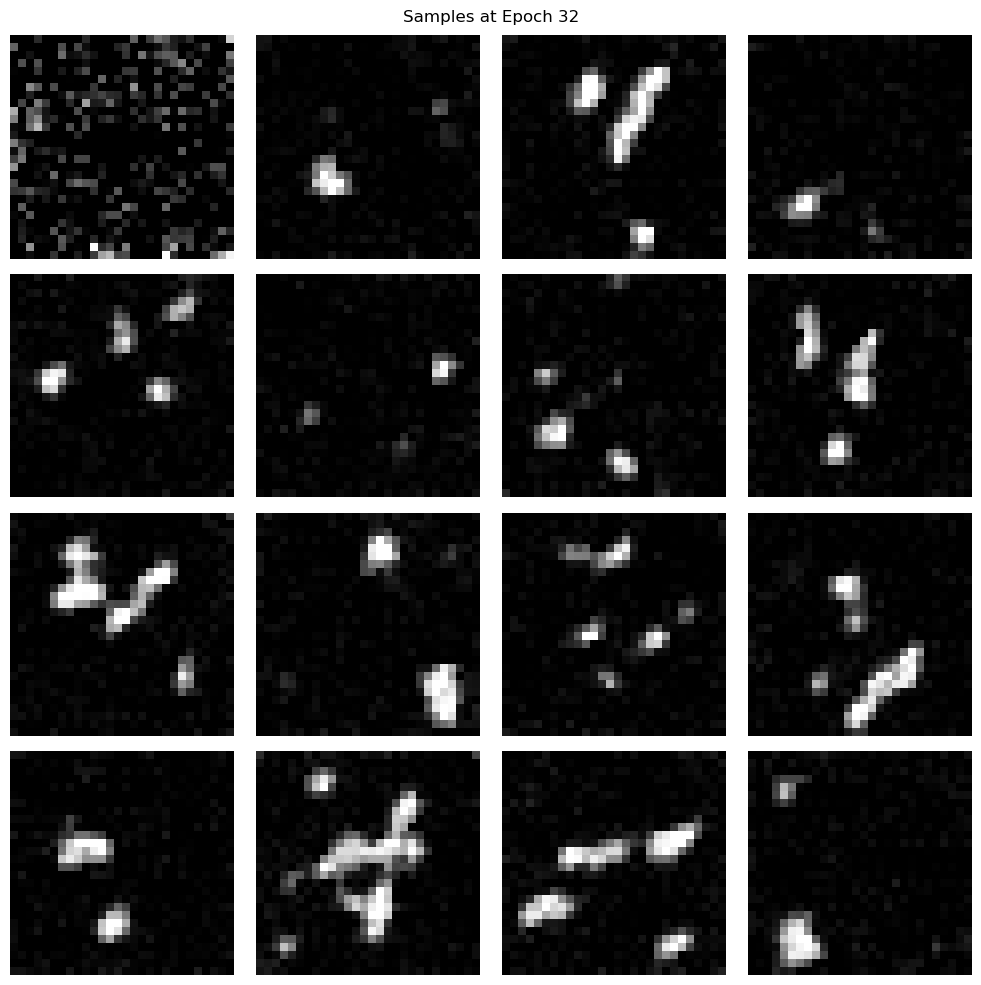

100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 33: Average Loss = 0.0623


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 34: Average Loss = 0.0579


100%|██████████| 1000/1000 [00:01<00:00, 523.55it/s]


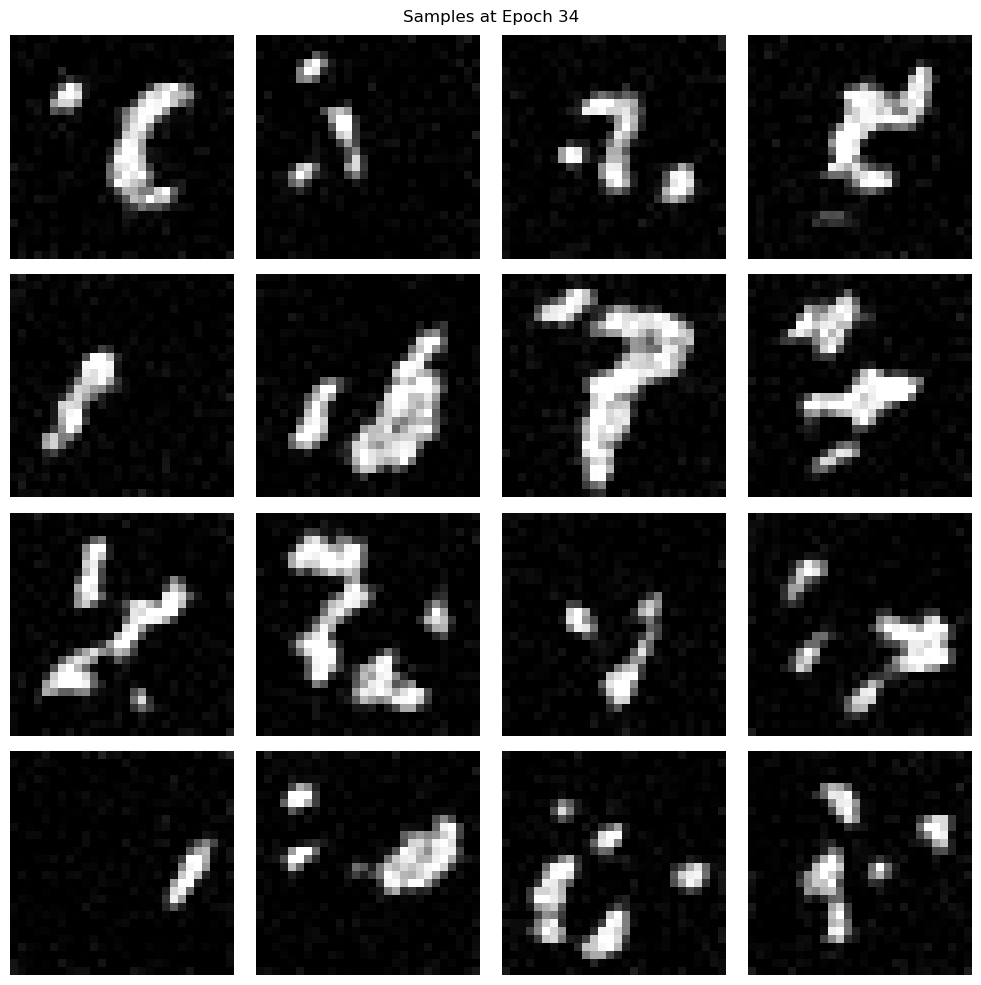

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 35: Average Loss = 0.0567


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 36: Average Loss = 0.0552


100%|██████████| 1000/1000 [00:01<00:00, 519.71it/s]


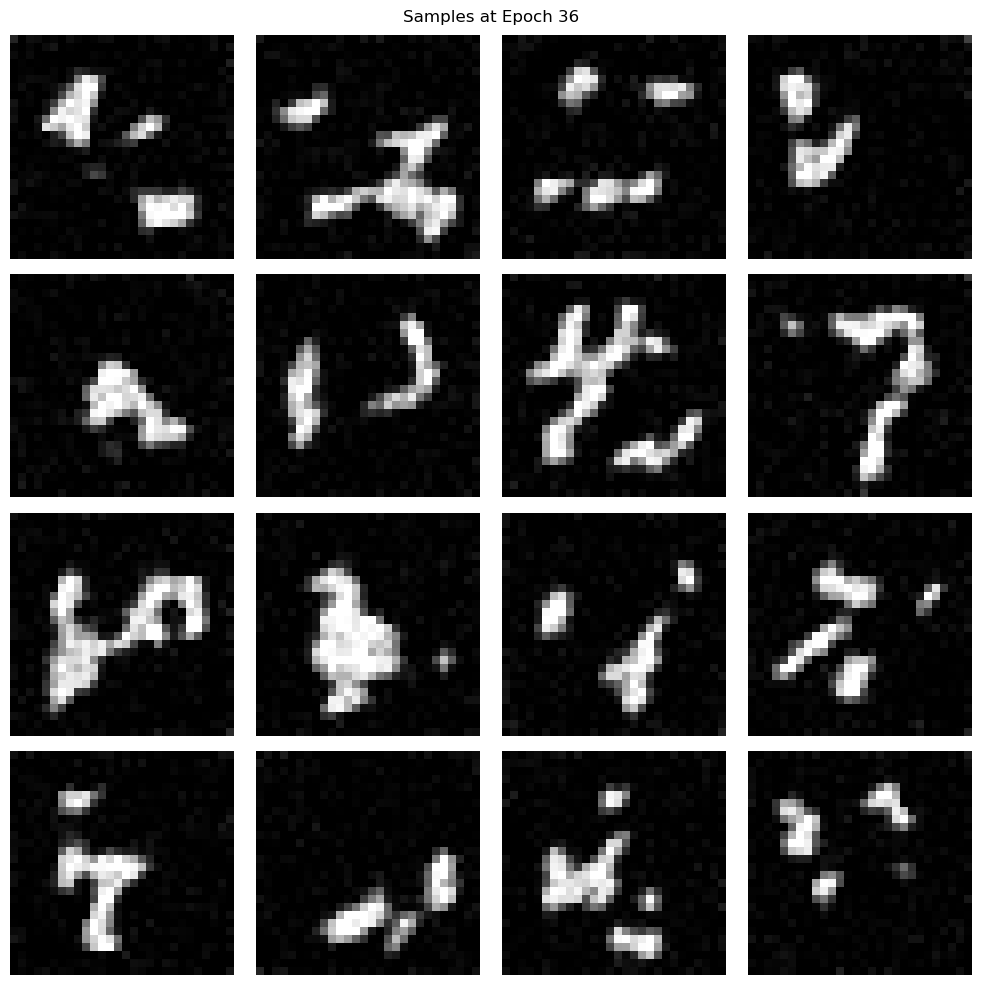

100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 37: Average Loss = 0.0550


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch 38: Average Loss = 0.0536


100%|██████████| 1000/1000 [00:01<00:00, 513.68it/s]


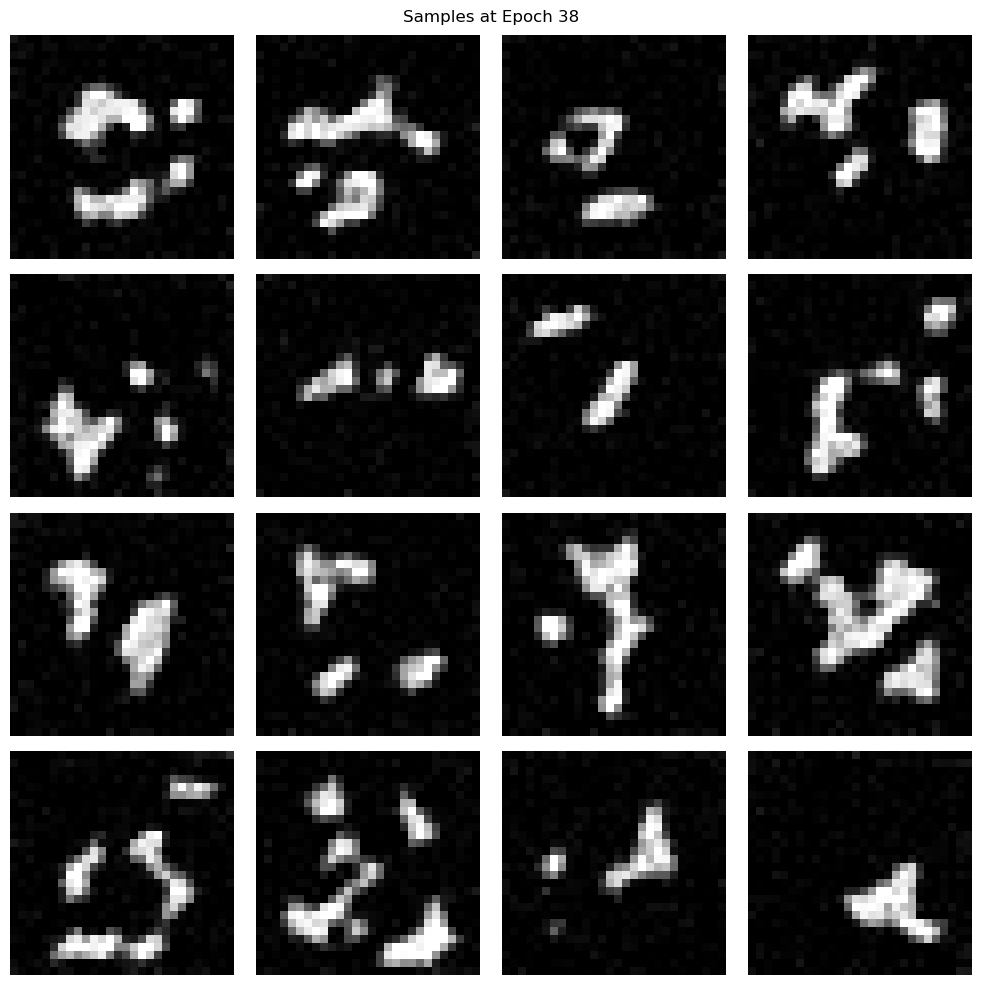

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 39: Average Loss = 0.0534


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 40: Average Loss = 0.0538


100%|██████████| 1000/1000 [00:01<00:00, 523.68it/s]


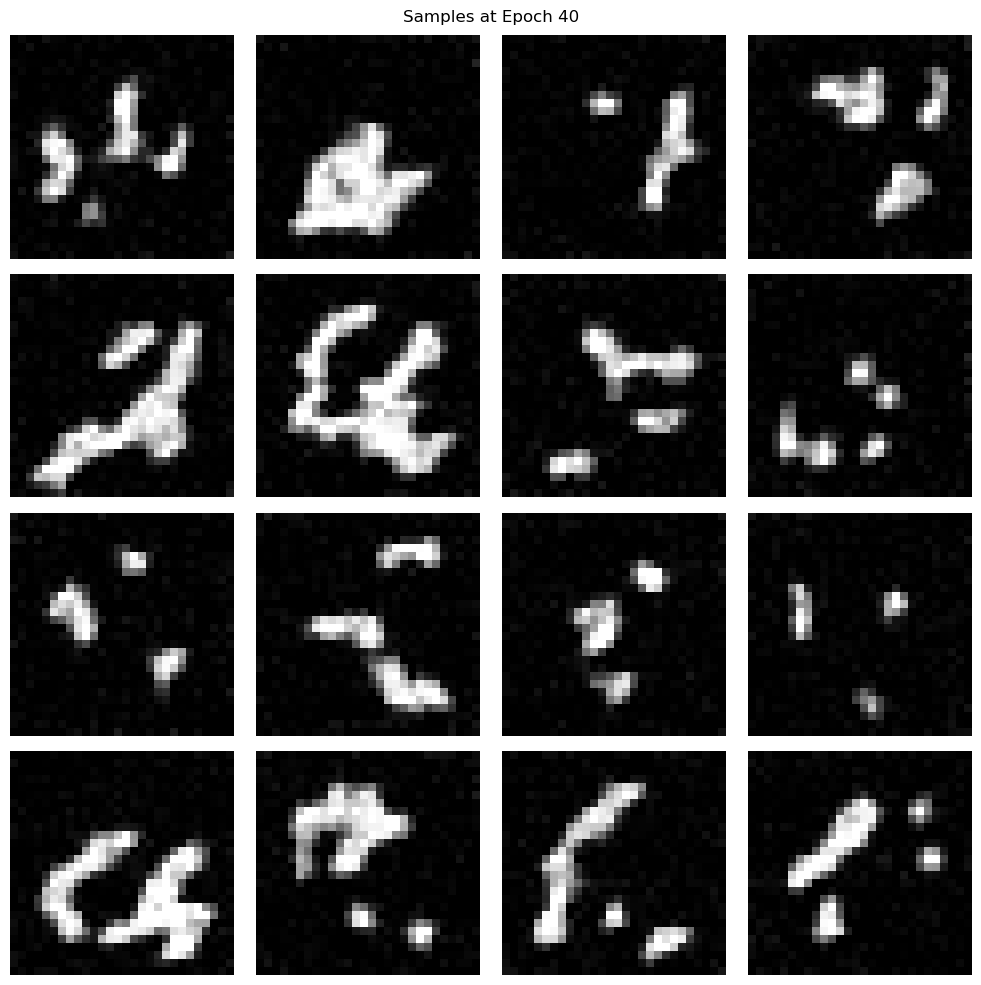

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 41: Average Loss = 0.0516


100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 42: Average Loss = 0.0522


100%|██████████| 1000/1000 [00:01<00:00, 512.02it/s]


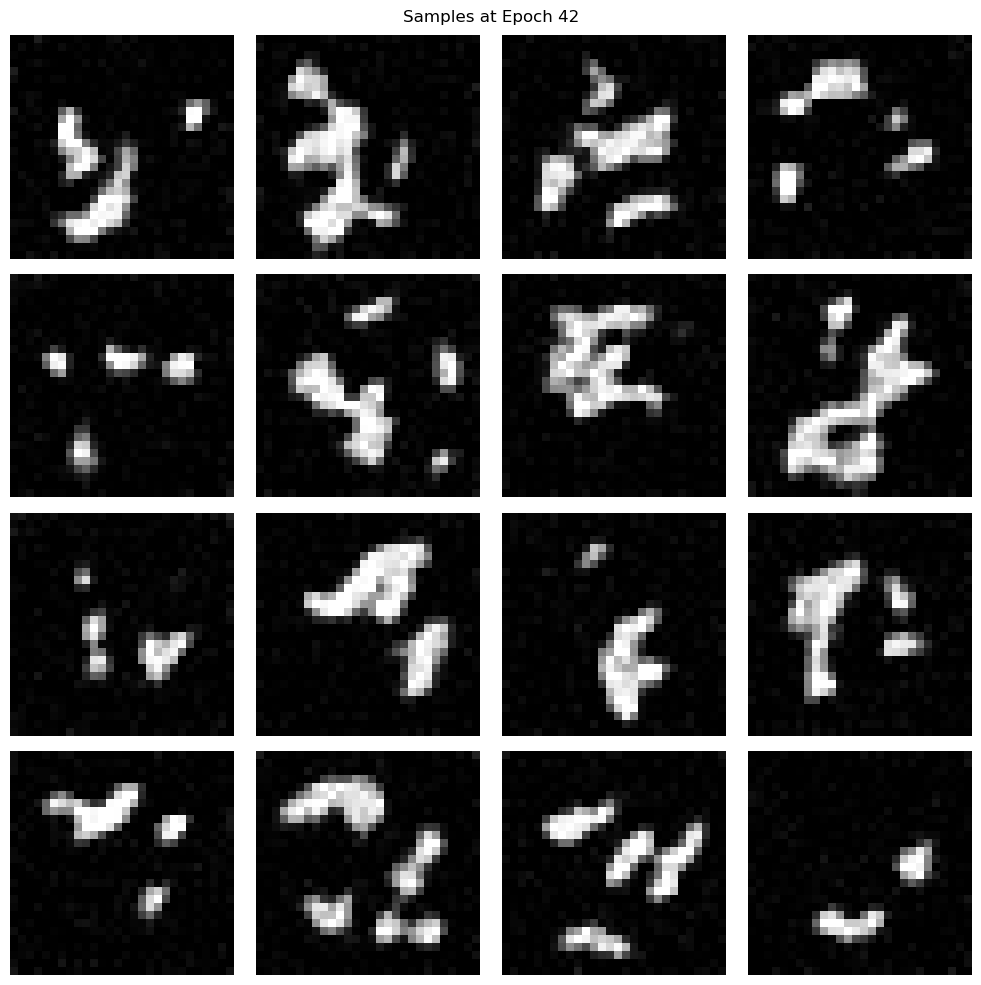

100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 43: Average Loss = 0.0522


100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 44: Average Loss = 0.0515


100%|██████████| 1000/1000 [00:01<00:00, 504.13it/s]


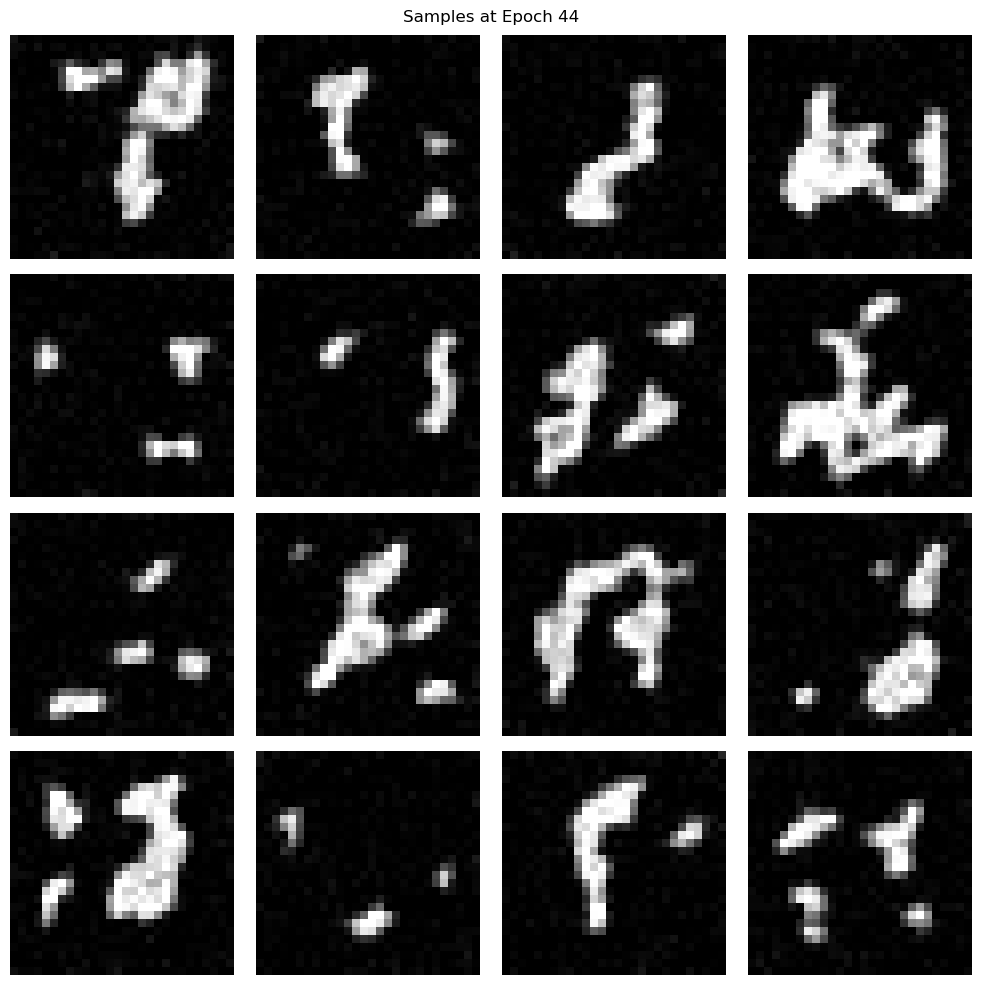

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 45: Average Loss = 0.0511


100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 46: Average Loss = 0.0499


100%|██████████| 1000/1000 [00:01<00:00, 514.70it/s]


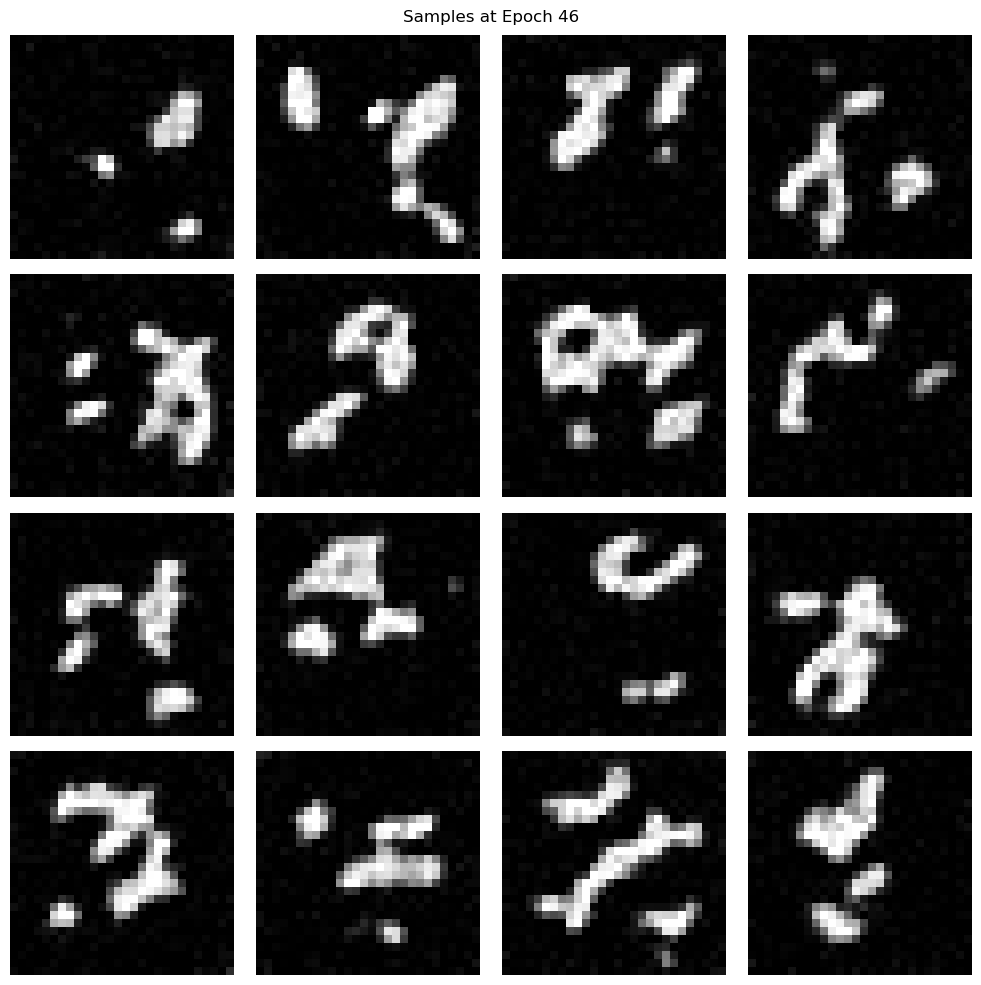

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 47: Average Loss = 0.0507


100%|██████████| 47/47 [00:21<00:00,  2.16it/s]


Epoch 48: Average Loss = 0.0503


100%|██████████| 1000/1000 [00:01<00:00, 506.93it/s]


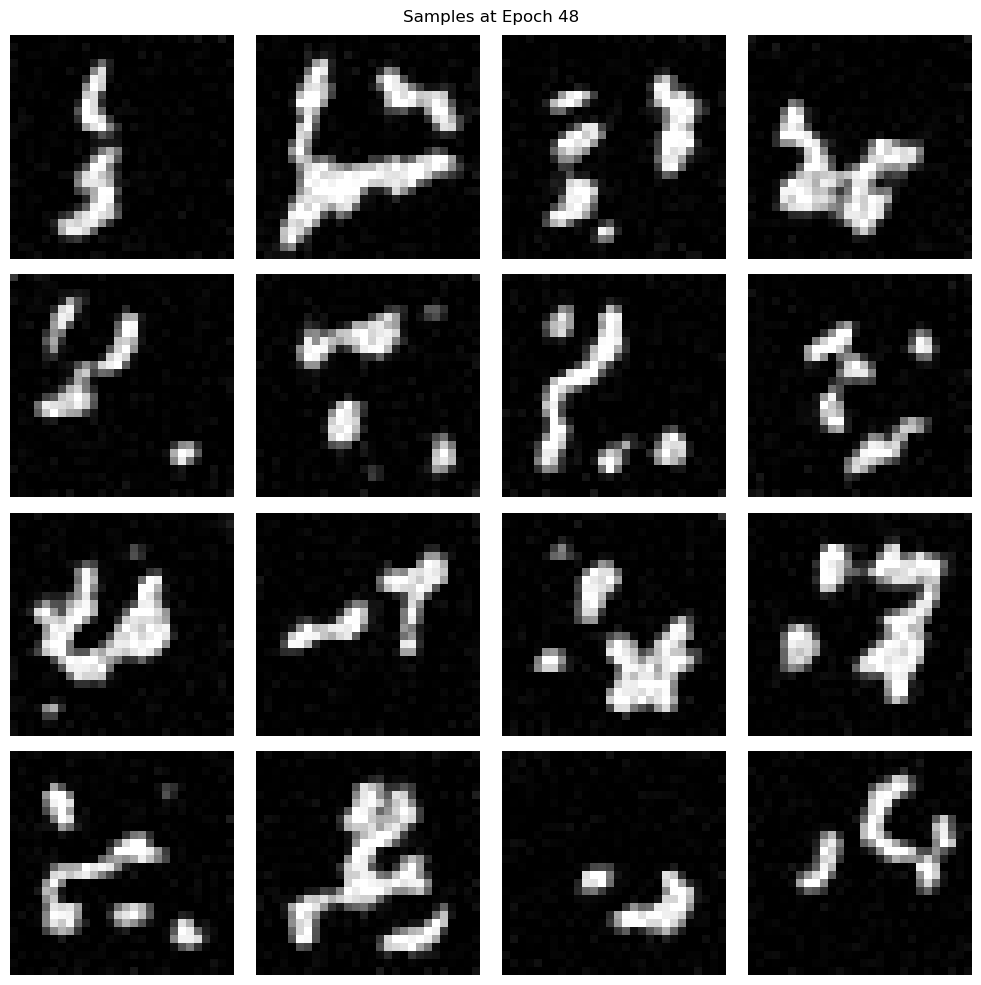

100%|██████████| 47/47 [00:21<00:00,  2.23it/s]


Epoch 49: Average Loss = 0.0505


100%|██████████| 1000/1000 [00:01<00:00, 508.66it/s]


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = get_mnist_dataloaders(batch_size=1280)

# Initialize models
eps_model = SimpleUNet().to(device)
diffusion = ddpm(eps_model, n_steps=1000, device=device)

# Train
train_diffusion(diffusion, eps_model, dataloader, n_epochs=50, device=device)

100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 0: Average Loss = 0.3302


100%|██████████| 1000/1000 [00:01<00:00, 516.48it/s]


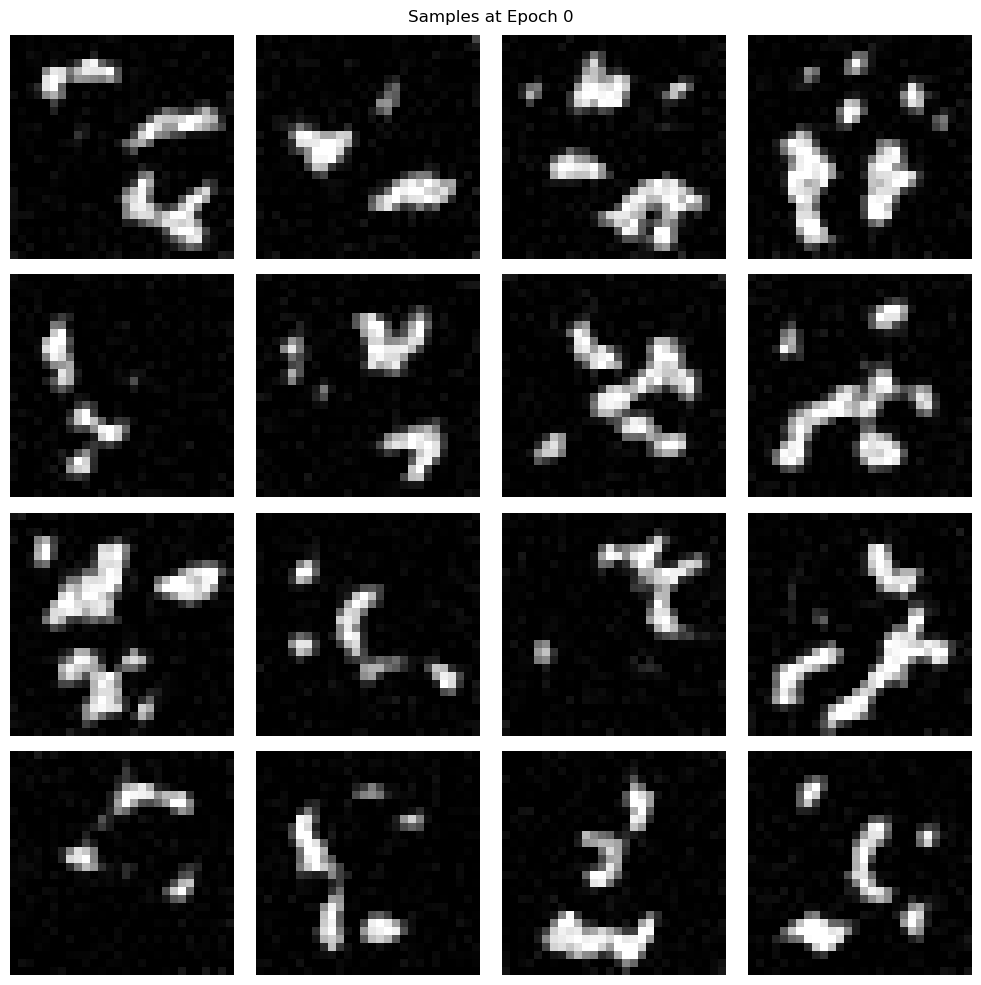

100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Epoch 1: Average Loss = 0.0607


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 2: Average Loss = 0.0554


100%|██████████| 1000/1000 [00:01<00:00, 524.30it/s]


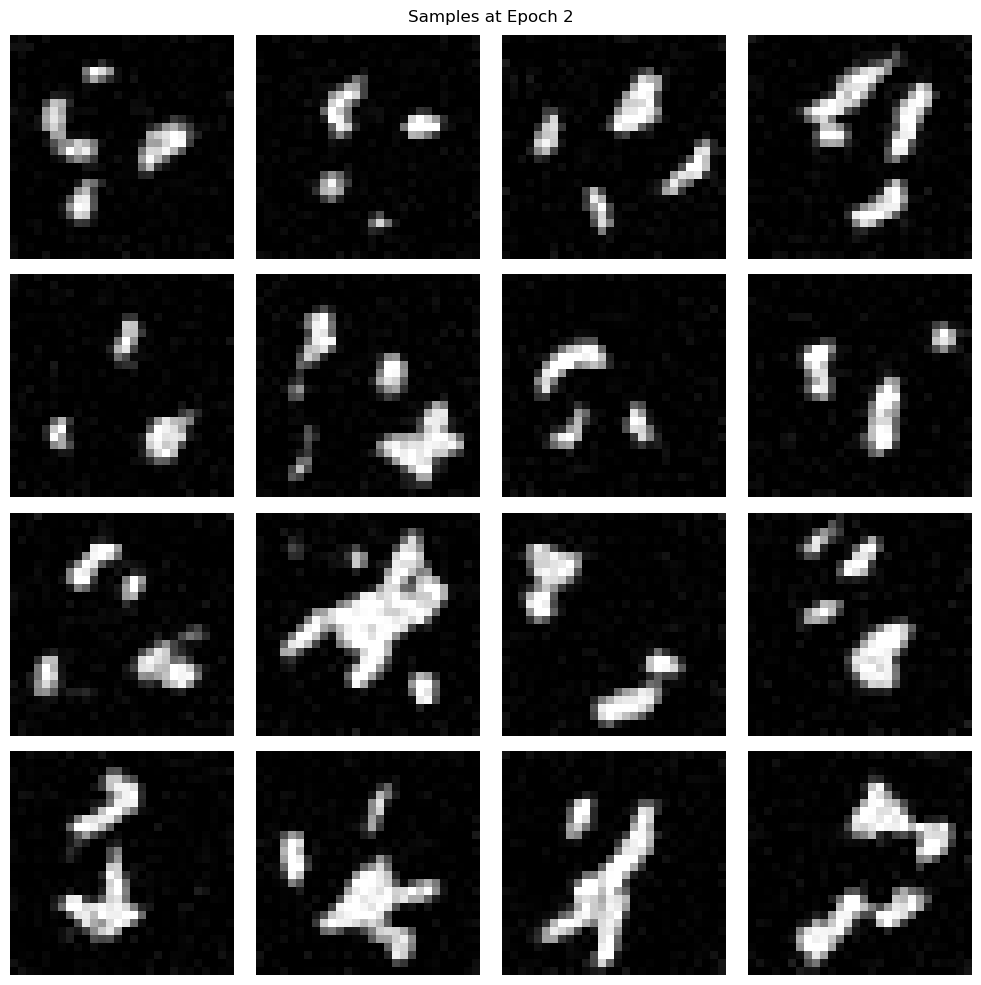

100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch 3: Average Loss = 0.0531


100%|██████████| 47/47 [00:21<00:00,  2.16it/s]


Epoch 4: Average Loss = 0.0516


100%|██████████| 1000/1000 [00:01<00:00, 507.13it/s]


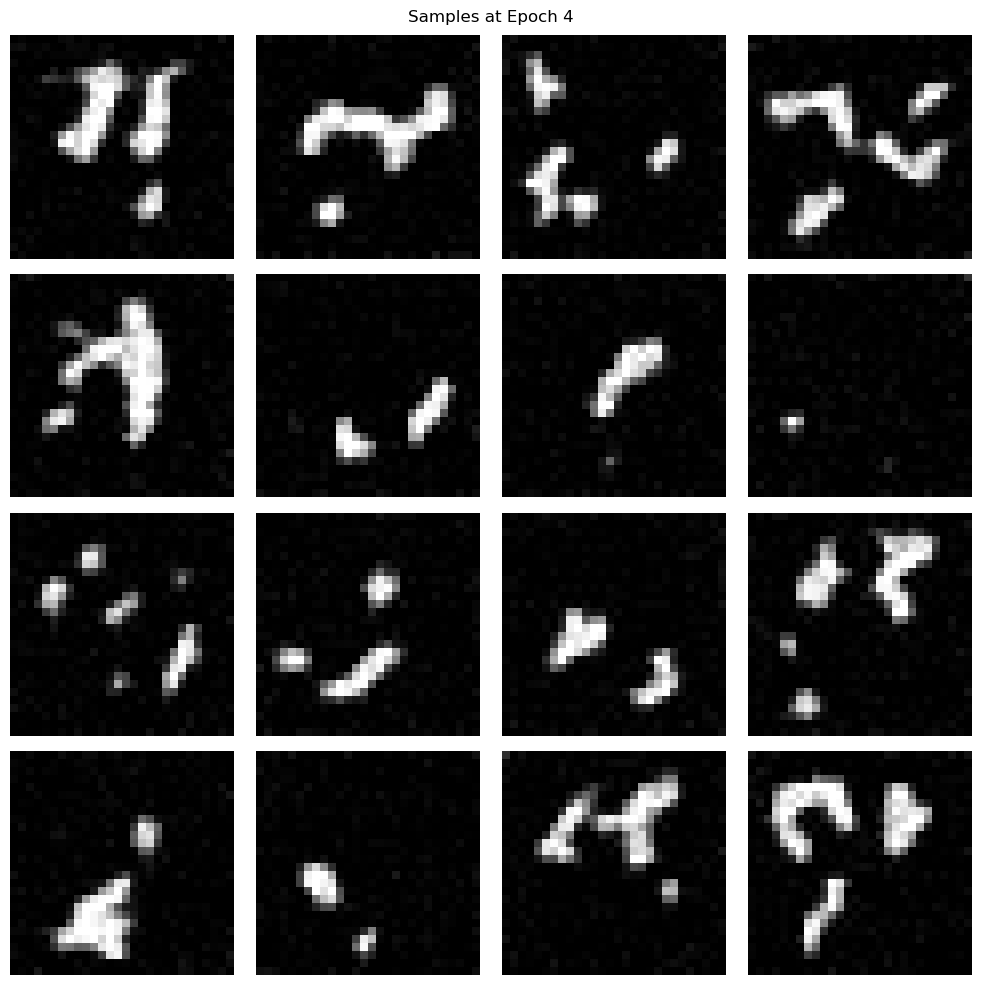

100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 5: Average Loss = 0.0507


100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


Epoch 6: Average Loss = 0.0501


100%|██████████| 1000/1000 [00:01<00:00, 526.23it/s]


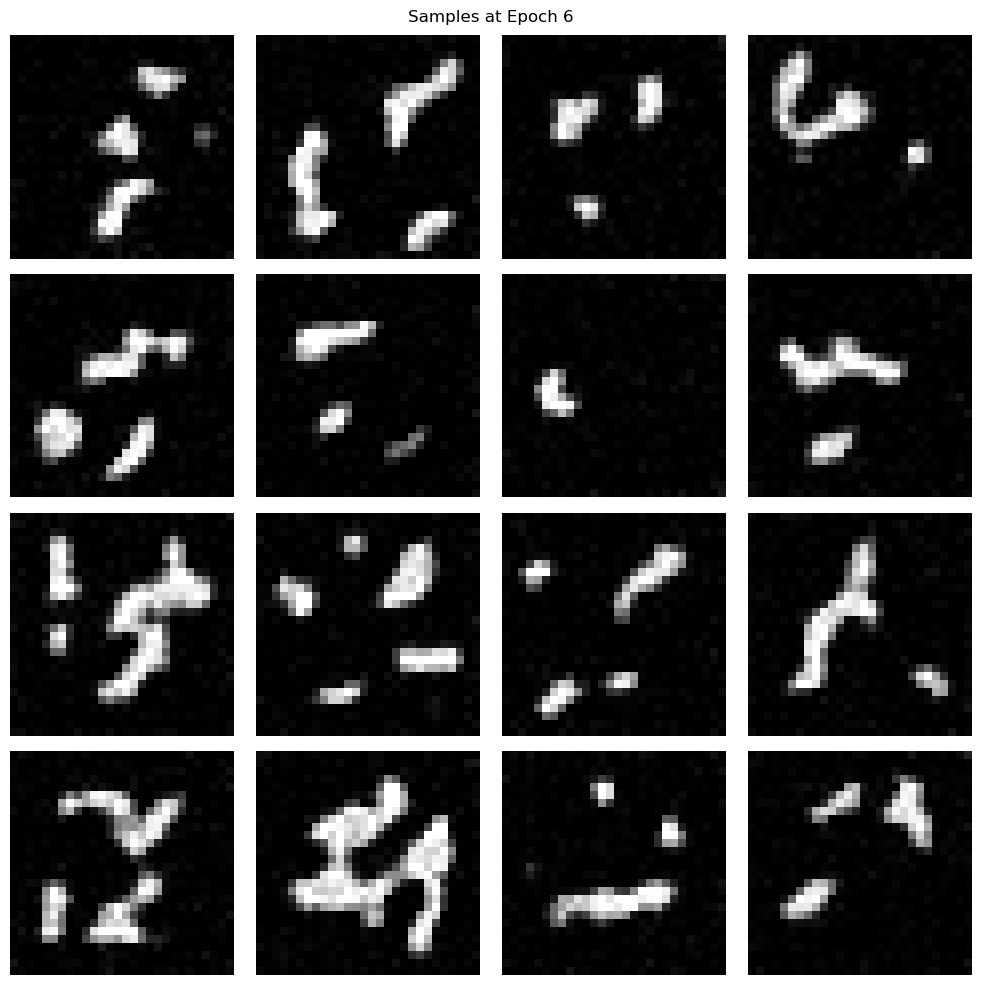

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]


Epoch 7: Average Loss = 0.0499


100%|██████████| 47/47 [00:22<00:00,  2.13it/s]


Epoch 8: Average Loss = 0.0492


100%|██████████| 1000/1000 [00:01<00:00, 515.54it/s]


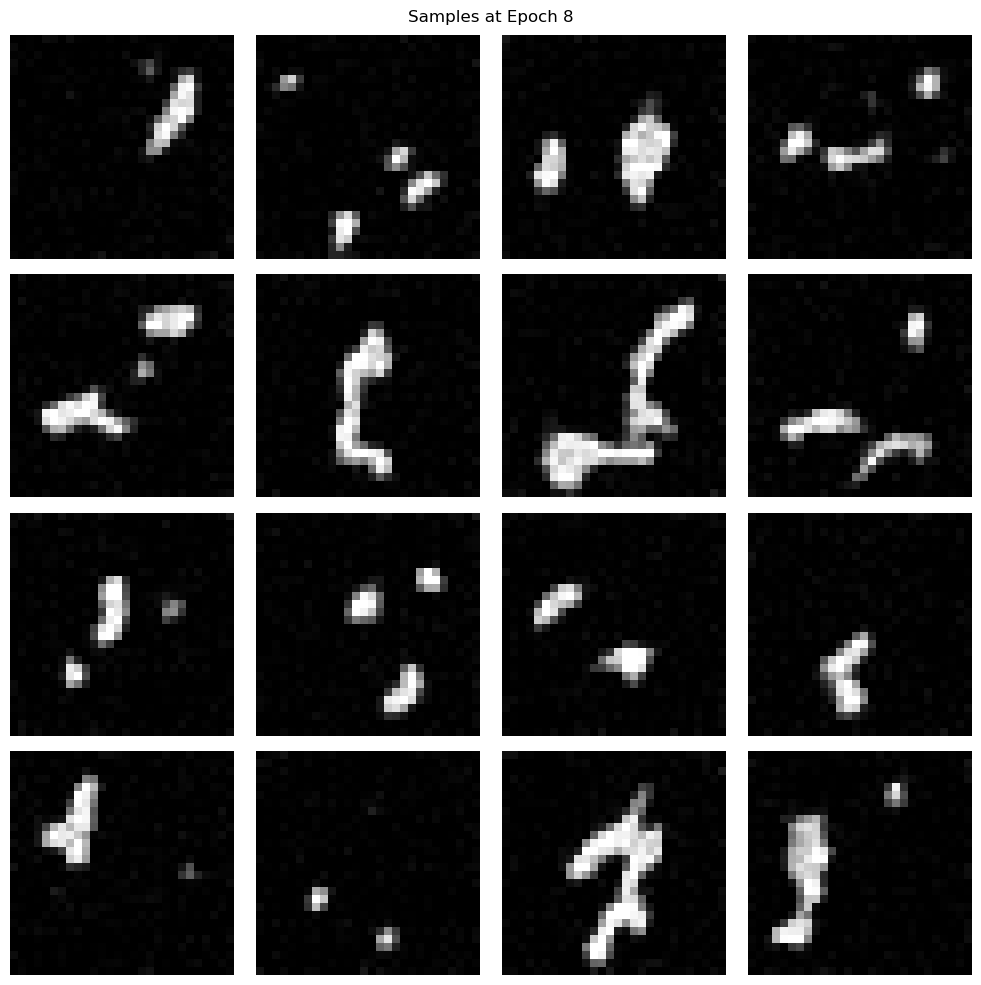

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

Epoch 9: Average Loss = 0.0480


In [19]:
# More training if needed
train_diffusion(diffusion, eps_model, dataloader, n_epochs=10, device=device)


100%|██████████| 1000/1000 [00:01<00:00, 520.28it/s]


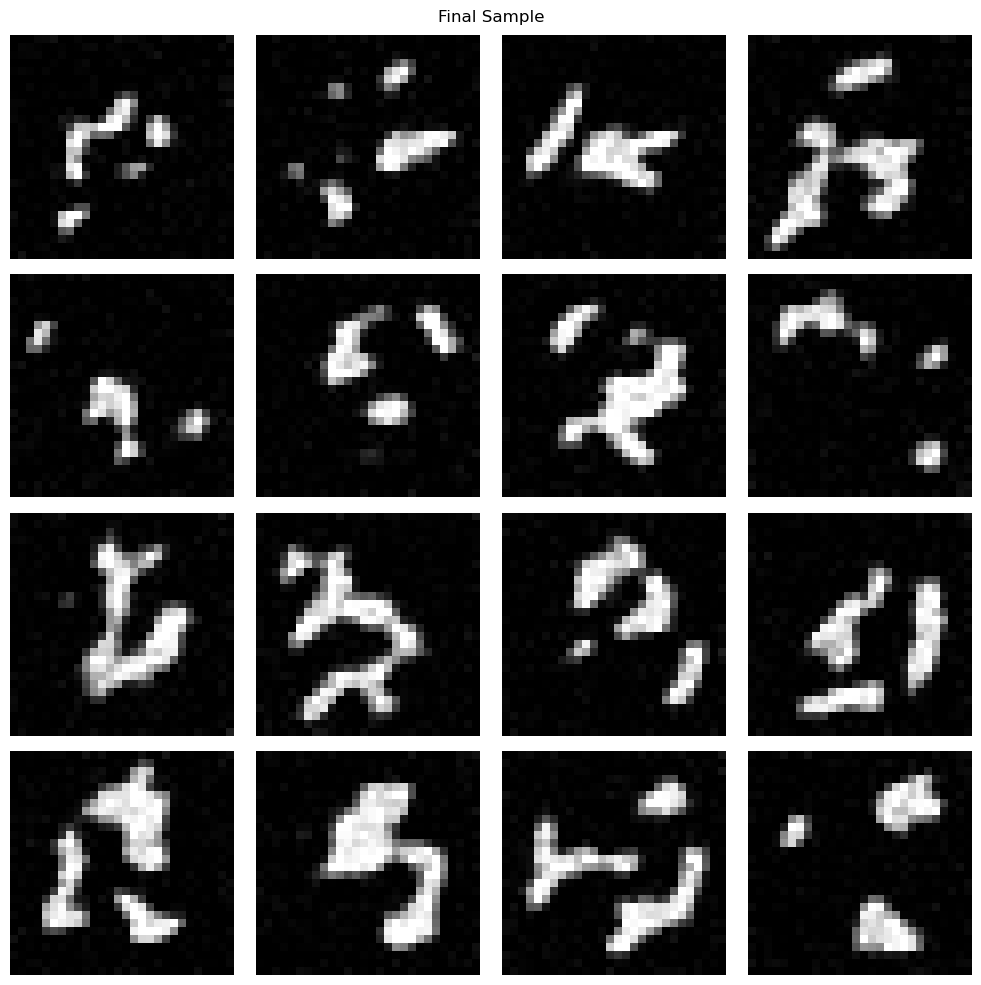

In [22]:
# Generate samples
samples = sample_images(diffusion, n_samples=16)

# Convert samples to display format
samples = samples.cpu().numpy()
samples = (samples + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
samples = samples.clip(0, 1)

# Create a grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='gray')
    ax.axis('off')

plt.suptitle(f'Final Sample')
plt.tight_layout()
plt.show()